In [75]:
# Import libriaries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import operator
from numba import jit

In [7]:
class Node:
    def __init__(self, data=None, left=None, right=None, p=0):        
        self.data = data
        self.left = left
        self.right = right
        self.p = p
    
    def __str__(self):
        if self.data == None:
            return "(None,%d)" % (self.p)
        return "(%d,%d)" % (self.data,self.p)
    
    def __repr__(self):
        if self.data == None:
            return "(None,%d)" % (self.p)
        return "(%d,%d)" % (self.data,self.p)

In [8]:
def lower_bound(x, vector):
    if len(vector) == 0:
        return 0
    l = 0
    r = len(vector) - 1
    while(r - l > 1):
        m = (l+r)//2
        if vector[m].p == x:
            return m
        elif x < vector[m].p:
            r = m
        else:
            l = m
            
    if vector[r].p <= x:
        return r
    if vector[l].p <= x:
        return l
    else:
        return 0

In [9]:
def generate_tree(intensities):
    
    if len(intensities) == 0:
        return Node()
    
    while len(intensities) > 1:
        left = intensities[1]
        right = intensities[0]
        node = Node(left=left, right=right, p = (left.p + right.p))
        
        intensities = intensities[2:]
        pos = lower_bound(node.p, intensities)
        intensities.insert(pos, node)
    
    return intensities[0]

In [47]:
def inorder(node, code=""):
    output = ""
    colors = {}
    if (node.left == None) and (node.right == None) and (node.data != None):
        output = ("%s %s\n" % (str(node.data), code))
        colors[node.data] = code
        
    if node.left != None:
        o,c = inorder(node.left, code+"1")
        output += o
        colors.update(c)
    if node.right != None:
        o,c = inorder(node.right, code+"0")
        output += o
        colors.update(c)
        
    return output,colors

In [48]:
def pre_processing(img):
    h,w = img.shape
    
    code = {}
    code['width'] = w
    code['height'] = h
    intensities = [(i,0) for i in range(256)]
    
    return code,intensities

In [49]:
def huffman(img):
    code,intensities = pre_processing(img)
    
    for row in range(code['height']):
        for col in range(code['width']):
            intensity = img[row,col]
            intensities[intensity] = ( intensity, intensities[intensity][1]+1 )
    intensities.sort(key = operator.itemgetter(1), reverse=True)
    max_index = 0
    
    code['intensity_p'] = []
    for (i,j) in intensities:
        if j == 0:
            break
        code['intensity_p'].append( Node(data=i,p=j) )
    
    code['intensity_p'].reverse()
    code['tree'] = generate_tree(code['intensity_p'])
    
    return code

In [52]:
def pad_encoded_text(encoded_text):
    extra_padding = 8 - len(encoded_text) % 8
    for i in range(extra_padding):
        encoded_text += "0"
        
    padded_info = "{0:08b}".format(extra_padding)
    encoded_text = padded_info + encoded_text
    return encoded_text

def get_byte_array(padded_encoded_text):
    if(len(padded_encoded_text) % 8 != 0):
        print("Encoded text not padded properly")
        exit(0)

    b = bytearray()
    for i in range(0, len(padded_encoded_text), 8):
        byte = padded_encoded_text[i:i+8]
        b.append(int(byte, 2))
    return b

def compress(img, code, filename):
    f = open(filename + '.vh', 'wb')    
    colors_str, colors_map = inorder(code['tree'])
    encoded_text = ""
    for row in range(code['height']):
        for col in range(code['width']):
            encoded_text += colors_map[ img[row,col] ]
    encoded_text = pad_encoded_text(encoded_text)
    b = get_byte_array(encoded_text)
    f.write(bytes(b))
    f.close()
    
    f = open(filename + '.config', 'w')
    f.write(str(code['width']) + '\n')
    f.write(str(code['height']) + '\n')
    f.write(colors_str)
    f.close    

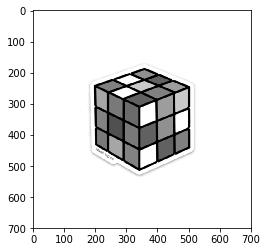

In [53]:
rubiks = cv2.imread('images/rubiks.png', 0)
code = huffman(rubiks)

plt.imshow(rubiks, cmap='gray')
plt.show()
compress(rubiks, code, "rubiks")

In [90]:
def get_config(fileconfig):
    code={}
    with open(fileconfig, 'r') as f:
        content = f.read()
        lines = content.split('\n')
        code['width'] = int(lines[0])
        code['height'] = int(lines[1])
        for line in lines[2:]:
            color_bin = line.split(' ')
            if len(color_bin) > 0:
                code[color_bin[1]] = color_bin[0]
    return code

def decode(code, config):
    image = np.zeros((config['height'],config['width']), dtype='uint8')
    for row in range(config['height']):
        for col in range(config['width']):
            value = -1
            current = ''
            while(code != ''):
                current += code[0]
                code = code[1:]
                if current in config:
                    value = int(config[current])
                    break
            image[row,col] = value
    return image

def decompress(filename, fileconfig):
    config = get_config(fileconfig)
    with open('rubiks.vh', 'rb') as f:
        code = ""
        byte = f.read(1)
        while byte != b"":
            # Do stuff with byte.
            code += bin( ord(byte) )[2:].rjust(8, '0')
            byte = f.read(1)    
    result = decode(code, config)
    plt.imshow(result, cmap='gray')
    plt.show()

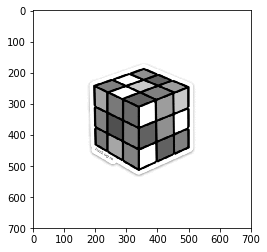

In [91]:
decompress("rubiks.vk", "rubiks.config")